# Boilerplate

In [1]:
# python internal 
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
print(os.getcwd())
import random
import re
import socket
print(socket.gethostname())
import shutil
import subprocess
import sys
# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta
# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

/mnt/home/pleung/projects/bistable_bundle/r3/hinges
dig31


# Flo's original approach
2. I design the states as "dimers", examplary run including the corresponding scripts can be found in `/home/flop/switch/5thround/DHRs/des_states6_np_all_flexbb/`

thus is the last round I did, nonpolar interface, flex bb, no selection before 
design. In earlier rounds I played around with polar interface design, 
fixedbb, only rigid body movement across the jump, keeping the bb fixed in one
of the two halves etc.

but I settled for the simple approach in des_states6

3. I then filtered the designed states using standard interface metrics. I made selections of different stringency, unfortunately IO did not save the exact criteria for the least stringent one that I ended up using

but I think it was probably something like interface_sc >= 0.65, score per res
<= -2.5, geometry == 1, and some kind of sasa/cms/ddG cutoff 
(or maybe not, i might hav ignored that one here)

# I will follow Flo's design procedure with some changes.
I will use the serialization build of PyRosetta to enable recording user defined info about the designs.  
This enables downstream inline filtering and data analysis, as well as clustering by lineage.
I will try using Hugh's 19A refit weights/scorefunction, as well as `beta_nov16` to compare their efficacy.  
I tried fixbb followed by flexbb design for the design, and took out a lot of the filters I didn't think were informative.

# Make functions for design and scoring

In [2]:
from pyrosetta.distributed.packed_pose.core import PackedPose
from pyrosetta.distributed import requires_init
from typing import *

@requires_init
def load(silent: str, **kwargs) -> Generator[str, PackedPose, None]:
    """Requires init. Because of some issues with silent energies, if your energy 
    is supposed to be a string but is an empty string  (""),
    it will be set to a float value of 0.0
    @pleung"""
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.rosetta.core.io.silent import SilentFileOptions, SilentFileData
    from pyrosetta.rosetta.core.pose import Pose
    if silent == None:
        silent = kwargs["-in:file:silent"]
    else:
        pass
    options = SilentFileOptions() 
    sfd = SilentFileData(options) # the part that requires init
    sfd.read_file(silent)
    for tag in sfd.tags():
        ss = sfd.get_structure(tag)
        ss_energies = list(ss.energies())
        pose = Pose()
        ss.fill_pose(pose)
        pose.pdb_info().name(tag)
        for energy in ss_energies:
            key = energy.name() 
            # takes advantage of string_value returning "" for true floats
            if energy.string_value() is not "":
                value = energy.string_value() 
            else: # if your energy is supposed to be an empty string it will be set to 0.0 here
                value = energy.value()
            pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
        ppose = io.to_packed(pose)
        yield ppose

        
def design(ppose: PackedPose, **kwargs) -> Generator[PackedPose, PackedPose, None]:
    """Generator of PackedPose objects, does 2rds. of fixbb design followed by 3rds. of flexbb design."""
    from copy import deepcopy
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import SingleoutputRosettaScriptsTask
    if ppose == None:
        ppose = io.pose_from_file(kwargs["s"])
    else:
        pass
    scores = deepcopy(ppose.pose.scores)
    if "sfxn" in kwargs:
        sfxn = kwargs["sfxn"]
    else:
        sfxn = "beta_nov16"
    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="{sfxn}" /> 
            <ScoreFunction name="sfxn_design" weights="{sfxn}" >
                <Reweight scoretype="res_type_constraint" weight="1.0" />
            </ScoreFunction>
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
            <Chain name="chA" chains="A"/>
            <Chain name="chB" chains="B"/>
            <Neighborhood name="interface_chA" selector="chB" distance="8.0" />
            <Neighborhood name="interface_chB" selector="chA" distance="8.0" />
            <And name="interface_AB" selectors="interface_chA,interface_chB" />
            <ResidueName name="pro_and_gly_positions" residue_name3="PRO,GLY" />
            <Or name="designable" selectors="interface_AB" />
            <Not name="not_designable" selector="designable" />
            <Layer name="surface" select_core="false" select_boundary="false" select_surface="true"
                use_sidechain_neighbors="true"/>
            <Layer name="boundary" select_core="false" select_boundary="true" select_surface="false" 
                use_sidechain_neighbors="true"/>
            <Layer name="core" select_core="true" select_boundary="false" select_surface="false" 
                use_sidechain_neighbors="true"/>
            <SecondaryStructure name="sheet" overlap="0" minH="3" minE="2" include_terminal_loops="false" 
                use_dssp="true" ss="E"/>
            <SecondaryStructure name="entire_loop" overlap="0" minH="3" minE="2" include_terminal_loops="true" 
                use_dssp="true" ss="L"/>
            <SecondaryStructure name="entire_helix" overlap="0" minH="3" minE="2" include_terminal_loops="false"
                use_dssp="true" ss="H"/>
            <And name="helix_cap" selectors="entire_loop">
                <PrimarySequenceNeighborhood lower="1" upper="0" selector="entire_helix"/>
            </And>
            <And name="helix_start" selectors="entire_helix">
                <PrimarySequenceNeighborhood lower="0" upper="1" selector="helix_cap"/>
            </And>
            <And name="helix" selectors="entire_helix">
                <Not selector="helix_start"/>
            </And>
            <And name="loop" selectors="entire_loop">
                <Not selector="helix_cap"/>
            </And>
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
            <DesignRestrictions name="layer_design">
                <Action selector_logic="surface AND helix_start"  aas="DEHKPQR"/>
                <Action selector_logic="surface AND helix"        aas="EHKQR"/>
                <Action selector_logic="surface AND sheet"        aas="EHKNQRST"/>
                <Action selector_logic="surface AND loop"         aas="DEGHKNPQRST"/>
                <Action selector_logic="boundary AND helix_start" aas="ADEHIKLNPQRSTVWY"/>
                <Action selector_logic="boundary AND helix"       aas="ADEHIKLNQRSTVWYM"/>
                <Action selector_logic="boundary AND sheet"       aas="DEFHIKLNQRSTVWY"/>
                <Action selector_logic="boundary AND loop"        aas="ADEFGHIKLNPQRSTVWY"/>
                <Action selector_logic="core AND helix_start"     aas="AFILVWYNQSTHP"/>
                <Action selector_logic="core AND helix"           aas="AFILVWM"/>
                <Action selector_logic="core AND sheet"           aas="FILVWY"/>
                <Action selector_logic="core AND loop"            aas="AFGILPVWYSM"/>
                <Action selector_logic="helix_cap"                aas="DNSTP"/>
            </DesignRestrictions>
            <PruneBuriedUnsats name="prune" allow_even_trades="false" 
                atomic_depth_cutoff="3.5" minimum_hbond_energy="-1.0"/>
            <ProteinProteinInterfaceUpweighter name="upweight_int" interface_weight="3" />
            <LimitAromaChi2 name="arochi" chi2max="110" chi2min="70" include_trp="True" />
            <ExtraRotamersGeneric name="ex1_ex2" ex1="1" ex2="1" />
            <OperateOnResidueSubset name="int_only" selector="not_designable">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>
            <OperateOnResidueSubset name="restrict_PRO_GLY" selector="pro_and_gly_positions">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>
        </TASKOPERATIONS>
        <FILTERS>
        </FILTERS>
        <MOVERS>
            <StructProfileMover name="gen_profile" add_csts_to_pose="1" consider_topN_frags="100" 
                eliminate_background="0" ignore_terminal_residue="1" only_loops="0"
                residue_selector="designable" burialWt="0" RMSthreshold="0.6" />
            <ClearConstraintsMover name="clear_constraints" />
            <FastDesign name="fixbb_with_jump" scorefxn="sfxn_design" repeats="1" 
                task_operations="arochi,ex1_ex2,upweight_int,restrict_PRO_GLY,layer_design,prune,int_only" 
                batch="false" ramp_down_constraints="false" cartesian="false" bondangle="false" 
                bondlength="false" min_type="dfpmin_armijo_nonmonotone" relaxscript="InterfaceDesign2019" >
                <MoveMap name="MM" >
                    <Chain number="1" chi="true" bb="false" />
                    <Chain number="2" chi="true" bb="false" />
                    <Jump number="1" setting="true" />
                </MoveMap>
            </FastDesign>
            <FastDesign name="flexbb_with_jump" scorefxn="sfxn_design" repeats="2"
                task_operations="arochi,ex1_ex2,upweight_int,restrict_PRO_GLY,layer_design,prune,int_only" 
                batch="false" ramp_down_constraints="false" cartesian="false" bondangle="false" 
                bondlength="false" min_type="dfpmin_armijo_nonmonotone" relaxscript="InterfaceDesign2019" >
                <MoveMap name="MM" >
                    <Chain number="1" chi="true" bb="true" />
                    <Chain number="2" chi="true" bb="true" />
                    <Jump number="1" setting="true" />
                </MoveMap>
            </FastDesign>
        </MOVERS>
        <APPLY_TO_POSE>
        </APPLY_TO_POSE>
        <PROTOCOLS>
            <Add mover="gen_profile" />
            <Add mover="fixbb_with_jump" />
            <Add mover="flexbb_with_jump" />
            <Add mover="clear_constraints" />
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """.format(sfxn=sfxn)
    fast_design = SingleoutputRosettaScriptsTask(xml)
    designed_ppose = fast_design(ppose.pose.clone())
    pose = io.to_pose(designed_ppose)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, "sfxn_used", sfxn)
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
    designed_ppose = io.to_packed(pose)
    yield designed_ppose

    
def score(ppose: PackedPose, **kwargs) -> PackedPose:
    from copy import deepcopy
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import SingleoutputRosettaScriptsTask
    if ppose == None:
        ppose = io.pose_from_file(kwargs["s"])
    else:
        pass
    scores = deepcopy(ppose.pose.scores)
    sfxn = ppose.pose.scores["sfxn_used"]
    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="{sfxn}" />            
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
            <Chain name="chA" chains="A"/>
            <Chain name="chB" chains="B"/>
            <Neighborhood name="interface_chA" selector="chB" distance="8.0" />
            <Neighborhood name="interface_chB" selector="chA" distance="8.0" />
            <And name="interface_AB" selectors="interface_chA,interface_chB" />            
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
            <ProteinInterfaceDesign name="pack_long" design_chain1="0" design_chain2="0" jump="1" interface_distance_cutoff="15"/>
        </TASKOPERATIONS>
        <MOVERS>
            <SwitchChainOrder name="cutB" chain_order="1" />
            <SwitchChainOrder name="cutA" chain_order="2" />
            <ScoreMover name="scorepose" scorefxn="sfxn" verbose="false" />
            <TaskAwareMinMover name="min" scorefxn="sfxn" bb="0" chi="1" task_operations="pack_long" />
        </MOVERS>
        <FILTERS>
            <Ddg name="ddg" threshold="-10" jump="1" repeats="5" repack="1" relax_mover="min" confidence="0" scorefxn="sfxn" />
            <Sasa name="interface_buried_sasa" confidence="0" />
            <SSShapeComplementarity name="sc" verbose="1" loops="1" helices="1" />
            <ShapeComplementarity name="sc_int" verbose="0" min_sc="0.55" write_int_area="1" write_median_dist="1" jump="1" confidence="0"/>
            <TaskAwareScoreType name="tot_score" scorefxn="sfxn" score_type="total_score" threshold="0" mode="total"  confidence="0" />
            <MoveBeforeFilter name="score_A" mover="cutB" filter="tot_score" confidence="0"/>
            <MoveBeforeFilter name="score_B" mover="cutA" filter="tot_score" confidence="0"/>
            <ScoreType name="total_score_pose" scorefxn="sfxn" score_type="total_score" threshold="0" confidence="0" />
            <ResidueCount name="count" />
            <CalculatorFilter name="score_per_res" equation="total_score_full / res" threshold="-2.0" confidence="0">
                <Var name="total_score_full" filter="total_score_pose"/>
                <Var name="res" filter="count"/>
            </CalculatorFilter>
        </FILTERS>
        <APPLY_TO_POSE>
        </APPLY_TO_POSE>
        <PROTOCOLS>
            <Add filter_name="ddg" />
            <Add filter_name="interface_buried_sasa" />
            <Add filter_name="sc" />
            <Add filter_name="sc_int" />
            <Add filter_name="score_A"/>
            <Add filter_name="score_B"/>
            <Add filter_name="score_per_res" />
        </PROTOCOLS>
        <OUTPUT scorefxn="sfxn" />
    </ROSETTASCRIPTS>
    """.format(sfxn=sfxn)
    scored = SingleoutputRosettaScriptsTask(xml)
    scored_ppose = scored(ppose.pose.clone())
    pose = io.to_pose(scored_ppose)
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
    scored_ppose = io.to_packed(pose)
    return scored_ppose

def join_flag_string(file:str) -> str:
    string = ""
    with open(file) as f:
        for line in f:
            if "#" not in line:
                string += line
            else:
                pass
    string.replace("\n", " ")
    return string

# Setup Dask
Trying a adaptive SLURMCluster. to see the dashboard, forward port `8787` to `8000`:  
`local$ ssh -L 8000:localhost:8787 $USER@$HOSTNAME`  
now, the web UI is visible at `localhost:8000` 

In [3]:
!echo $HOSTNAME
!echo $USER

dig31
pleung


In [4]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=1,
                       processes=1,
                       job_cpu=1,
                       memory="8GB",
                       queue="medium",
                       walltime="23:30:00", # try to prevent death timeouts
                       death_timeout=1200,
                      )
print(cluster.job_script())
cluster.adapt(minimum=0, maximum=500, wait_count=400)  # scale between 0 and 500 workers
client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /home/pleung/logs/slurm_logs/dask-worker-%J.err
#SBATCH -o /home/pleung/logs/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=8G
#SBATCH -t 23:30:00

/home/pleung/.conda/envs/cereal/bin/python -m distributed.cli.dask_worker tcp://172.16.131.61:42275 --nthreads 1 --memory-limit 8.00GB --name name --nanny --death-timeout 1200 --local-directory $TMPDIR/dask --no-nanny --no-dashboard



Client Scheduler: tcp://172.16.131.61:42275 Dashboard: http://172.16.131.61:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
# client.close(); cluster.close()

# Set command line options, make tasks and submit to client

In [ ]:
import logging
import pyrosetta.distributed.io as io
from pyrosetta.distributed.cluster.core import PyRosettaCluster

logging.basicConfig(level=logging.INFO)
silents = glob(os.path.join(os.getcwd(), "01_silents/states.silent")) 

options = { 
    "-out:level": "300",
    "-in:file:silent_struct_type": "binary",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",
    "-dunbrack_prob_buried": "0.8",
    "-dunbrack_prob_nonburied": "0.8", 
    "-dunbrack_prob_buried_semi": "0.8", 
    "-dunbrack_prob_nonburied_semi": "0.8",
    "-run:constant_seed" : "1",
}

def create_tasks(silents, options):
    for silent in silents:
        for sfxn in ["beta_nov16"]:
            tasks = {"options": "-corrections::beta_nov16 true"}
            tasks["extra_options"] = options
            tasks["set_logging_handler"] = "interactive"
            tasks["-in:file:silent"] = silent
            tasks["sfxn"] = sfxn
            yield tasks
        
if not os.getenv("DEBUG"):
    output_path = os.path.join(os.getcwd(), "02_design_and_filter")
    PyRosettaCluster(
        tasks=create_tasks(silents, options),
        client=client,
        scratch_dir=output_path,
        output_path=output_path,
        nstruct=5,
        seeds = [1, 1, 1],        
    ).distribute(protocols=[load, design, score])

`conda env export --prefix /home/pleung/.conda/envs/cereal > environment.yml`
to reproduce this simulation later.
INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/cereal/lib/python3.7/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2020.50+release.1295438cd4bd2be39c9dbbfab8db669ab62415ab 2020-12-12T00:30:01] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


https://docs.anaconda.com/anaconda/install



In [8]:
def read_scorefile(scores):
    import pandas as pd
    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores
    
output_path = os.path.join(os.getcwd(), "02_design_and_filter")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

,bb_clash,ddg,dslf_fa13,fa_atr,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,...,sc,sc_int,scaffold,score,score_A,score_B,score_per_res,sfxn_used,shift,total_score
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/02_design_and_filter/decoys/0000/2021.01.30.16.45.35.626088_930aa863de36469c9f12dc410d577671.pdb.bz2,52.073002,-54.431225,0.0,-1015.669330,19.063715,130.842085,172.491780,-391.248022,-54.84208,-32.297157,...,0.734896,0.752452,DHR,0.0,-136.843033,-140.311844,-2.937613,beta_nov16,-6.0,-499.394271
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/02_design_and_filter/decoys/0000/2021.01.30.16.45.35.626088_fb65fab0c21140a59ec97393e3d3477a.pdb.bz2,52.073002,-54.431225,0.0,-1015.669330,19.063715,130.842085,172.491780,-391.248022,-54.84208,-32.297157,...,0.734896,0.752452,DHR,0.0,-136.843033,-140.311844,-2.937613,beta_nov16,-6.0,-499.394271
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/02_design_and_filter/decoys/0000/2021.01.30.16.45.35.626088_62ced049c27440a09f248adfe2d3e9f7.pdb.bz2,52.073002,-54.431225,0.0,-1015.669330,19.063715,130.842085,172.491780,-391.248022,-54.84208,-32.297157,...,0.734896,0.752452,DHR,0.0,-136.843033,-140.311844,-2.937613,beta_nov16,-6.0,-499.394271
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/02_design_and_filter/decoys/0000/2021.01.30.16.45.35.626088_2f116a9dc97e4238a18bcf97434ad329.pdb.bz2,52.073002,-54.431225,0.0,-1015.669330,19.063715,130.842085,172.491780,-391.248022,-54.84208,-32.297157,...,0.734896,0.752452,DHR,0.0,-136.843033,-140.311844,-2.937613,beta_nov16,-6.0,-499.394271
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/02_design_and_filter/decoys/0000/2021.01.30.16.45.35.626088_ddcbe455e2e44adcafd880735a7b7d29.pdb.bz2,72.022003,-57.479305,0.0,-1555.829182,40.152479,198.055226,330.753166,-584.105766,-93.29321,-33.371942,...,0.766944,0.769717,DHR,0.0,-205.332657,-205.814911,-3.009745,beta_nov16,-3.0,-722.338814


In [9]:
len(scores_df)

100

In [10]:
scores_df.columns

Index(['bb_clash', 'ddg', 'dslf_fa13', 'fa_atr', 'fa_dun_dev', 'fa_dun_rot',
       'fa_dun_semi', 'fa_elec', 'fa_intra_atr_xover4', 'fa_intra_elec',
       'fa_intra_rep_xover4', 'fa_intra_sol_xover4', 'fa_rep', 'fa_sol',
       'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'hxl_tors',
       'interface_buried_sasa', 'lk_ball', 'lk_ball_bridge',
       'lk_ball_bridge_uncpl', 'lk_ball_iso', 'omega', 'p_aa_pp', 'parent',
       'parent_length', 'pivot_helix', 'pre_break_helix', 'pro_close',
       'rama_prepro', 'ref', 'sc', 'sc_int', 'scaffold', 'score', 'score_A',
       'score_B', 'score_per_res', 'sfxn_used', 'shift', 'total_score'],
      dtype='object')

In [11]:
scores_df.groupby(["scaffold"]).mean()

,bb_clash,ddg,dslf_fa13,fa_atr,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,...,rama_prepro,ref,sc,sc_int,score,score_A,score_B,score_per_res,shift,total_score
scaffold,,,,,,,,,,,,,,,,,,,,,
DHR,1215.113227,-80.356221,0.0,-1308.480657,33.256903,160.978854,242.589268,-473.697869,-75.428753,-38.308924,...,18.046082,-64.148683,0.736801,0.761167,0.0,-155.111007,-163.703727,-2.925641,-0.333333,-609.023056
THR,85.201833,-76.714766,0.0,-1971.586203,52.605416,239.589064,367.072788,-633.288855,-124.455442,-52.572606,...,110.450394,-88.626121,0.696083,0.774295,0.0,-253.181379,-264.131808,-2.876699,-0.333333,-882.471007
TH_DHR,659.674484,-120.492718,0.0,-1701.858425,47.707478,231.207276,298.101631,-617.099131,-103.885224,-54.948514,...,2.208536,-22.668882,0.742670,0.728135,0.0,-214.173195,-218.828957,-3.080953,0.500000,-841.141233


In [18]:
scores_df["pivot_helix"] = scores_df["pivot_helix"].astype(float).astype(int)
scores_df["pre_break_helix"] = scores_df["pre_break_helix"].astype(float).astype(int)
scores_df["shift"] = scores_df["shift"].astype(float).astype(int)

/mnt/home/pleung/projects/bistable_bundle/r3/hinges/02_design_and_filter/decoys/0000/2021.01.30.16.45.35.626088_930aa863de36469c9f12dc410d577671.pdb.bz2    4
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/02_design_and_filter/decoys/0000/2021.01.30.16.45.35.626088_fb65fab0c21140a59ec97393e3d3477a.pdb.bz2    4
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/02_design_and_filter/decoys/0000/2021.01.30.16.45.35.626088_62ced049c27440a09f248adfe2d3e9f7.pdb.bz2    4
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/02_design_and_filter/decoys/0000/2021.01.30.16.45.35.626088_2f116a9dc97e4238a18bcf97434ad329.pdb.bz2    4
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/02_design_and_filter/decoys/0000/2021.01.30.16.45.35.626088_ddcbe455e2e44adcafd880735a7b7d29.pdb.bz2    4
                                                                                                                                                           ..
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '-6.0'),
  Text(1, 0, '-4.0'),
  Text(2, 0, '-3.0'),
  Text(3, 0, '-1.0'),
  Text(4, 0, '0.0'),
  Text(5, 0, '1.0'),
  Text(6, 0, '3.0'),
  Text(7, 0, '6.0'),
  Text(8, 0, '7.0')])

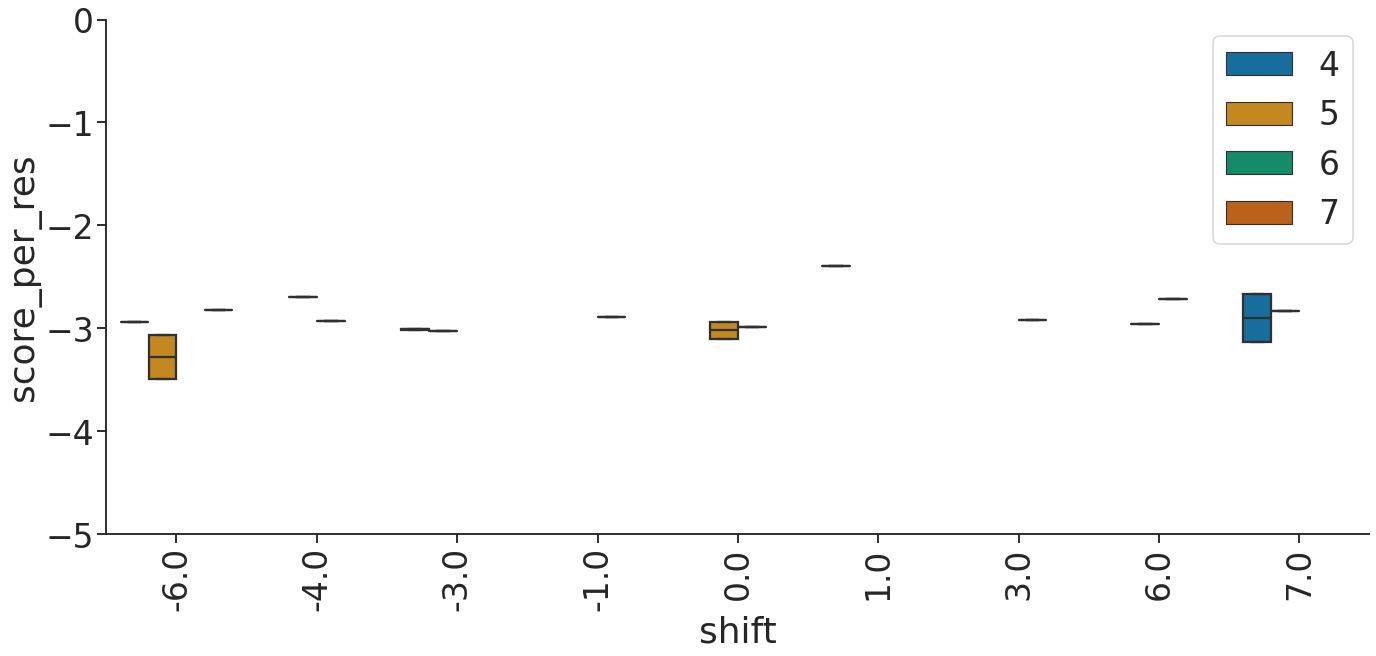

In [19]:
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
sns.set(
    context="talk",
    font_scale=2, # make the font larger; default is pretty small
    style="ticks", # make the background white with black lines
    palette="colorblind" # a color palette that is colorblind friendly!
)

order = list(set(scores_df["shift"].values))
order.sort()

fig = plt.figure(figsize=(20,10), tight_layout=True)
pivot_order = [4, 5, 6, 7]
ax = sns.boxplot(
    x="shift", y="score_per_res", data=scores_df,
    order= order, showfliers=False,
    hue="pivot_helix", hue_order=pivot_order,
)
ax.legend(loc="upper right")
ax.set_ylim(-5, 0)
sns.despine()
plt.setp(ax.get_legend().get_title(), fontsize='24')
plt.xticks(rotation=90)
plt.savefig("figs/02_shift_vs_score_per_res_groupby_pivot.png")

In [20]:
# sorted_parents = sorted(list(set(scores_df.parent.values)))
# thrs = [x for x in sorted_parents if "THR" in x]
# dhrs_nocys = [x for x in sorted_parents if "nocys" in x]
# th_dhrs = [x for x in sorted_parents if "TH_DHR" in x]
# dhrs = [x for x in sorted_parents if ("THR" not in x and "nocys" not in x and "TH_DHR" not in x)]

In [21]:
# data_orders = [dhrs, dhrs_nocys, th_dhrs, thrs]
# fig, axs = plt.subplots(2, 2, sharey=True, figsize=(30,30))
# fig.suptitle("Parent vs. Clash")
# fig.subplots_adjust(wspace=0.2)
# fig.subplots_adjust(hspace=0.5)
# for order, ax in zip(data_orders, axs.flatten()):
#     ax.tick_params(axis="x", labelrotation=45)
#     ax.set_ylim(0, 250000)
#     sns.boxplot(
#         ax=ax,
#         x="parent", y="bb_clash", data=scores_df,
#         order=order, showfliers = False,
#     )
#     sns.stripplot(
#         ax=ax,
#         x="parent", y="bb_clash", data=scores_df,
#         order=order,
#     )
#     sns.despine()
# axs[0][0].set_title("DHRS"); axs[0][1].set_title("no_cys")
# axs[1][0].set_title("TH_DHRS"); axs[1][1].set_title("THRS")
# plt.show()
# plt.savefig("figs/01_all_parents_vs_clash.png")

In [22]:
# data_orders = [dhrs, dhrs_nocys, th_dhrs, thrs]
# pivot_orders = [['4', '5'], ['4', '5'], ['4', '5'], ['6', '7']]
# fig, axs = plt.subplots(2, 2, sharey=True, figsize=(30,30))
# fig.suptitle("Parent vs. Clash, Subgrouped by Pivot Order")
# fig.subplots_adjust(wspace=0.2)
# fig.subplots_adjust(hspace=0.5)
# for order, ax, pivot_order in zip(data_orders, axs.flatten(), pivot_orders):
#     ax.tick_params(axis="x", labelrotation=45)
#     ax.set_ylim(0, 250000)
#     sns.boxplot(
#         ax=ax,
#         x="parent", y="bb_clash", data=scores_df,
#         order=order, showfliers = False,
#         hue="pivot_helix", hue_order=pivot_order,
#     )
#     sns.stripplot(
#         ax=ax,
#         x="parent", y="bb_clash", data=scores_df,
#         order=order,
#         hue="pivot_helix", hue_order=pivot_order,
#     )
#     sns.despine()
#     ax.legend(loc="upper right")
# axs[0][0].set_title("DHRS"); axs[0][1].set_title("no_cys")
# axs[1][0].set_title("TH_DHRS"); axs[1][1].set_title("THRS")
# plt.show()
# plt.savefig("figs/01_all_parents_vs_clash_subgrouped_pivots.png")

# Let's do more analysis
First group into major scaffold classes

In [23]:
# scaffold = []
# for value in scores_df.parent.values:
#     if "TH_" not in value:
#         name = value[0:3]
#     else:
#         name = value[0:6]
#     scaffold.append(name)
# scores_df["scaffold"] = scaffold
# scores_df.groupby(["scaffold"]).mean()

In [24]:
# palette = list(sns.color_palette("colorblind", 256).as_hex())
# palette = palette[:3]
# scaffold_classes = sorted(list(set(scores_df.scaffold.values)))
# color_dict = dict(zip(scaffold_classes, palette))

# x = [int(x) for x in scores_df["pivot_helix"]]
# y = [int(x) for x in scores_df["shift"]]
# z = list(scores_df["bb_clash"])
# c = [color_dict[x] for x in list(scores_df["scaffold"])]

# fig = plt.figure(figsize=(20,20), tight_layout=True)
# ax = fig.add_subplot(111, projection="3d")
# sc = ax.scatter(x, y, z, c=c, s=100, alpha=0.7)
# ax.set_xlabel("pivot", labelpad=100)
# ax.set_ylabel("shift", labelpad=100)
# ax.set_zlabel("clash", labelpad=100)
# ax.set_zlim(0,250000)
# ax.tick_params(axis="both", labelrotation=-45)
# ax.set_xticks([4,5,6,7])
# ax.set_yticks(range(-7,8))
# axs[0][0].set_title("DHRS"); axs[0][1].set_title("no_cys")
# markers = [plt.Line2D([0,0],[0,0],color=color, marker="o", markersize=20, linestyle="") for color in color_dict.values()]
# plt.legend(markers, color_dict.keys(), numpoints=1)
# plt.savefig("figs/01_pivot_vs_shift_vs_clash_subgrouped_scaffolds.png")
# plt.show()

# Observations
1. TODO

# Get decoys that pass a TODO
<!-- my pilot runs seemed to indicate that flo was right, starting `bb_clash` score doesnt seem to be predictive of final interface quality...   
... at least `score_per_res` anyway -->

In [25]:
# cutoffs, num = [], []
# fig = plt.figure(figsize=(15,10), tight_layout=True)

# for cutoff in range(50, 500000, 50):
#     filtered = scores_df[scores_df["bb_clash"] < cutoff]
#     cutoffs.append(cutoff), num.append(len(filtered))
    
# ax = sns.lineplot(x=cutoffs, y=num)
# sns.despine()
# ax.set_xscale("log")
# _ = plt.xticks([100,1000,10000,100000])
# plt.xlabel("bb_clash cutoff")
# plt.ylabel("count")
# plt.savefig("figs/01_cutoff_vs_count.png")

# I think a flat cutoff of around TODO

In [26]:
# selected = scores_df[scores_df["bb_clash"] < 20000]
# print(len(selected), "selected structures")

In [27]:
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10), tight_layout=True)
# scores_df.groupby("scaffold").size().plot(kind="pie", autopct="%1.2f%%", ax=ax1)
# selected.groupby("scaffold").size().plot(kind="pie", autopct="%1.2f%%", ax=ax2)
# ax1.set_ylabel("Pre selection")
# ax2.set_ylabel("Post selection")
# plt.tight_layout()
# plt.savefig("figs/pre_post_selection.png")

# Parallel unzipping, relabeling and packing into a silent of all selected designs
Method maintains score info

In [28]:
import pyrosetta.distributed.io as io
from pyrosetta.distributed.packed_pose.core import PackedPose

def unpack_add_scores_repack(bz2file:str, scores:dict) -> PackedPose:
    import bz2
    import os
    import pyrosetta
    import pyrosetta.distributed.io as io
    with open(bz2file, "rb") as f:
        ppose = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
    pose = io.to_pose(ppose)
    basename =  os.path.basename(bz2file.replace(".pdb.bz", "", 1))
    pose.pdb_info().name(basename)
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
    final_ppose = io.to_packed(pose)
    return final_ppose

if not os.getenv("DEBUG"):
    future_pposes = []
    for i, bz2file in enumerate(scores_df.index, start=1): # TODO
        # decompress from bz2, add score info and pack
        scores_dict = dict(scores_df.loc[bz2file])
        future_ppose = client.submit(unpack_add_scores_repack, bz2file, scores_dict)
        future_pposes.append(future_ppose)
    pposes = []
    for future in tqdm(future_pposes):
        pposes.append(future.result())

out_path = os.path.join(os.getcwd(), "02_silents")
silent_name = "states.silent"

os.makedirs(out_path, exist_ok=True)
io.to_silent(pposes, os.path.join(out_path, silent_name))
msg = """
out_path: {out_path}
packed {i} poses
""".format(out_path=out_path, i=i)
print(msg)

100%|██████████| 100/100 [00:36<00:00,  2.75it/s]



out_path: /mnt/home/pleung/projects/bistable_bundle/r3/hinges/02_silents
packed 100 poses



In [ ]:
client.close(); cluster.close()